In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch import optim
from torch import nn
from tqdm import tqdm
import random


### **Hyperparameters**

In [234]:
learning_rate = 0.01
batch_size = 128
num_epochs = 20
start = 1747
stop = 3000

In [212]:
# Define path to custom image
black_path = r'.\MyBlackDataset'

In [213]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

dataset = ImageFolder(root=black_path, transform=transform)
classes = ('black','random')


In [214]:
num_samples = 650
random_sampler = torch.utils.data.RandomSampler(dataset, num_samples=num_samples)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=random_sampler, num_workers = 4, persistent_workers=True)
#train_size = 3000
#indices = random.sample(range(len(dataset)), train_size)
#trainset = torch.utils.data.Subset(dataset, indices)

# Create DataLoader for this subset
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

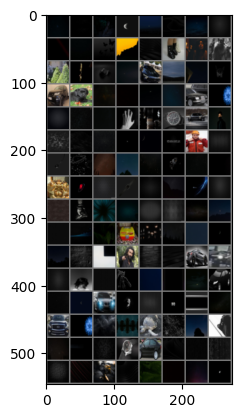

black black black black black black black black black black black black black black black black random black black black black black black black black black black black black black black black black black black black black black black black black black black black black black random black black black black black black black black black random black black black black black black black black black black black black black black black black black black random black black black black black black black black black black black black black black black black black black black black black black black black black black black black black black black black random black black black black black black black black black black black black black black black black black black black


In [215]:
import matplotlib.pyplot as plt
import numpy as np

def showimage(img):
  img = img /2 + 0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

#get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

#show images
showimage(torchvision.utils.make_grid(images))
#show labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

**DEFINE CNN**

In [3]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # First convolutional layer (in_channels, out_channels, kernel_size) , out_channels = number of filters
    # 3 input channels, 6 output channels, 5x5 kernel size
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 2)
  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x))) #apply conv. then apply pooling
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = self.fc1(x)
    return x

NameError: name 'nn' is not defined

**SETUP DEVICE**

In [216]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### **TRAIN and SAVE models**

In [ ]:
for i in range(start,stop):
    print(f"Model {i}")
    random_sampler = torch.utils.data.RandomSampler(dataset, num_samples=num_samples)
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=random_sampler, num_workers = 4, persistent_workers=True)

    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
      print(f"Epoch [{epoch +1 }/{num_epochs}]")
      for batch_index, (data,targets) in enumerate(tqdm(trainloader)):
        #Move data and targets to device (GPU/CPU)
        data = data.to(device)
        targets = targets.to(device)
    
        #Forward pass: compute model output
        scores = model(data)
        loss = criterion(scores,targets)
    
        #Backward pass: compute the gradients
        optimizer.zero_grad()
        loss.backward()
    
        # Optimization step: update model parameters
        optimizer.step()

    PATH = f'./black_models/black_model_{i:04}.pth'
    torch.save(model.state_dict(),PATH)
    print(f"{PATH} SAVED\n")

In [2]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

#layer 0 and 2 are conv2d layers
layer = 0
PATH = f'./black_models/black_model_2747.pth'
features = []
lmodel = CNN()
lmodel.load_state_dict(torch.load(PATH, weights_only=True))
for key,value in lmodel._modules.items():
    features.append(value)

print(features)
print("\nLayer ",layer)
filter = features[layer].weight.data.clone()
#print(f"COnv2d = {features[0].weight.data}")
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

NameError: name 'CNN' is not defined

In [243]:
testset = ImageFolder(root='./black_test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 25)

def check_accuracy(loader, model):
    """
    Checks the accuracy of the model on the given dataset loader.

    Parameters:
        loader: DataLoader
            The DataLoader for the dataset to check accuracy on.
        model: nn.Module
            The neural network model.
    """
    #if loader.dataset.train:
     #   print("Checking accuracy on training data")
    #else:
     #   print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass: compute the model output
            scores = model(x)
            _, predictions = scores.max(1)  # Get the index of the max log-probability
            num_correct += (predictions == y).sum()  # Count correct predictions
            num_samples += predictions.size(0)  # Count total samples

        # Calculate accuracy
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")

    model.train()  # Set the model back to training mode

# Final accuracy check on training and test sets
check_accuracy(trainloader, lmodel.to(device))
check_accuracy(testloader, lmodel.to(device))

Got 635/650 with accuracy 97.69%
Got 20/25 with accuracy 80.00%


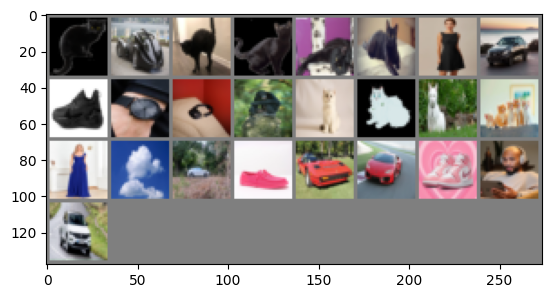

GroundTruth:  black black black black black black black black black black black black random random random random random random random random random random random random random
Predicted:  black black black black black random black black black random random black random random black random random random random random random black random random random


In [244]:

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
showimage(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(25)))

#send images to gpu
images = images.to(device)

outputs = lmodel(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(25)))